In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [2]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda


In [3]:
torch.cuda.is_available()

True

In [4]:
print(torch.__version__)

2.1.2


In [5]:
import glob

data_path = 'russian_lit_data'
copy_path = 'copyrighted'
noncopy_path = 'uncopyrighted'
rus_path = 'russian'

copy_files = glob.glob(data_path + '/' + copy_path + '/*.txt')
noncopy_files = glob.glob(data_path + '/' + noncopy_path + '/*.txt')
files = copy_files + noncopy_files

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kkatsy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# create dict: translator to books
# NotesFromUnderground - Katz, PV, Garnett
# PoorFolk - McDuff, Hogarth, Garnett

translator_to_sents = {}
translator_to_sents_holdout = {}
holdout_books = ['PoorFolk', 'NotesFromUnderground']
for f in files:
    book_title = (f.split('/')[-1]).split('.')[0]
    book_name = book_title.split('_')[0]
    translator = book_title.split('_')[1]

    if translator not in translator_to_sents.keys():
        translator_to_sents[translator] = []
        translator_to_sents_holdout[translator] = []

    with open(f, "r") as fp:
        book_text = fp.read()
        book_pars = book_text.split('\n')
        sents = []

        for par in book_pars:
            if len(par) > 40 and len(par) < int(490/2):
                # par_sents = nltk.tokenize.sent_tokenize(par)
                # long_sents = [s for s in par_sents if len(s) > 40]
                if book_name in holdout_books:
                    translator_to_sents_holdout[translator].extend(par)
                else:
                    translator_to_sents[translator].extend(par)

In [10]:
total = 0
print('Train')
for k in translator_to_sents.keys():
    print(k, len(translator_to_sents[k]))
    total += len(translator_to_sents[k])
print('Total', total)

total = 0
print('\nHoldout')
for k in translator_to_sents_holdout.keys():
    print(k, len(translator_to_sents_holdout[k]))
    total += len(translator_to_sents_holdout[k])
print('Total', total)

Train
McDuff 991991
PV 2132356
Garnett 1948960
Katz 687930
Hogarth 273824
Total 6035061

Holdout
McDuff 11009
PV 31731
Garnett 40108
Katz 41341
Hogarth 4833
Total 129022


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(translator_to_sents.keys()))
print(le.transform(["Garnett", "McDuff", "PV", "Katz", "Hogarth"]))

[0 3 4 2 1]


In [10]:
# for each translator
# split each book into sentences with sent_tokenizer
# drop sentences shorter than 6 words
# add to data dict: {'idx': 0, 'label': 1, 'sentence': "Our friends won't buy this analysis, let alone the next one we propose."}
data_list = []
i = 0
for tr in translator_to_sents.keys():
    label = le.transform([tr])[0]
    for s in translator_to_sents[tr]:
        sent_dict = {'idx': i, 'labels': label, 'sentence': s}
        data_list.append(sent_dict)
        i += 1

data_list_holdout = []
i = 0
for tr in translator_to_sents_holdout.keys():
    label = le.transform([tr])[0]
    for s in translator_to_sents_holdout[tr]:
        sent_dict = {'idx': i, 'labels': label, 'sentence': s}
        data_list_holdout.append(sent_dict)
        i += 1
        
print(data_list[:10])

[{'idx': 0, 'labels': 3, 'sentence': 'Aleksey Fyodorovich Karamazov was the third son of a landowner in our district, Fyodor Pavlovich Karamazov, so noted in his time (and even now still recollected among us) for his tragic and fishy death, which occurred just thirteen years ago and which I shall report in its proper context.'}, {'idx': 1, 'labels': 3, 'sentence': "'landowner' (as he was called among us, though for most of his life he hardly ever lived on his estate at all) is that he was a strange type, one that is, however, rather often encountered, namely the type of man who is not only empty and depraved but also muddle-headed — belonging, though, to the class of muddle-headed men who are perfectly well able to handle their little property affairs, and, it would seem, these alone."}, {'idx': 2, 'labels': 3, 'sentence': "Fyodor Pavlovich, for example, began with practically nothing, was a landowner of the very least important category, went trotting around other people's dinner tabl

In [11]:
import pandas as pd

df = pd.DataFrame(data_list)
df_holdout = pd.DataFrame(data_list_holdout)
df.head()

,idx,labels,sentence
0,0,3,Aleksey Fyodorovich Karamazov was the third so...
1,1,3,"'landowner' (as he was called among us, though..."
2,2,3,"Fyodor Pavlovich, for example, began with prac..."
3,3,3,And yet at the same time he had persisted all ...
4,4,3,I repeat: here there was no question of stupid...


In [12]:
# from sklearn.utils import shuffle
# df = shuffle(df)
# df = df.head(100000)
df.shape
df_holdout.shape

(12535, 3)

In [13]:
from sklearn.model_selection import train_test_split

# train_texts = df['sentence'].values.tolist()
# train_labels = df['labels'].values.tolist()
test_texts = df_holdout['sentence'].values.tolist()
test_labels = df_holdout['labels'].values.tolist()

train_texts, _, train_labels, _ = train_test_split(
    df['sentence'].values.tolist(), df['labels'].values.tolist(),
    stratify = df['labels'], train_size=0.55, shuffle=True
)

print('train size: ', len(list(train_labels)))
print('test size: ', len(list(test_labels)))

sentences = {}
sentences['train'] = []
sentences['test'] = []
for t, l in zip(train_texts, train_labels):
    datum = {'label': l, 'text': t}
    sentences['train'].append(datum)
for t, l in zip(test_texts, test_labels):
    datum = {'label': l, 'text': t}
    sentences['test'].append(datum)

print(sentences['train'][4])

train size:  112122
test size:  12535
{'label': 0, 'text': 'Varvara Petrovna prized such visits highly, as her connections in higher circles had grown weaker and weaker since the death of her husband, and had at last ceased altogether.'}


In [14]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [15]:
import datasets

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

In [16]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/112122 [00:00<?, ? examples/s]

Map:   0%|          | 0/12535 [00:00<?, ? examples/s]

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
label_list = translator_to_sents.keys()
id_list = le.transform(list(label_list))

id2label = {}
label2id = {}
for l, i in zip(label_list, id_list):
    id2label[i] = l
    label2id[l] = i

print(id2label)
print(label2id)

{3: 'McDuff', 4: 'PV', 0: 'Garnett', 2: 'Katz', 1: 'Hogarth'}
{'McDuff': 3, 'PV': 4, 'Garnett': 0, 'Katz': 2, 'Hogarth': 1}


In [20]:
fine_tune = False

In [21]:
from numpy import mean
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# device (turn on GPU acceleration for faster execution)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if fine_tune:
    # model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(translator_to_sents.keys()))
    model.to(device)

In [22]:
device

device(type='cuda')

In [23]:
lr = 2e-5
epochs = 10
batch_size = 16

In [24]:
import wandb

run = wandb.init(
        # Set the project where this run will be logged
        project="translator-classification",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

os.environ["WANDB_PROJECT"]="translator-classification"
os.environ["WANDB_NOTEBOOK_NAME"]="translator_classification"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kkatsy. Use `wandb login --relogin` to force relogin


In [25]:
if fine_tune:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/classification_10epochs_holdout",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

In [26]:
if fine_tune:
    trainer.train()

In [27]:
if fine_tune:
    trainer.evaluate()

In [28]:
# import gc

# del model
# gc.collect()
# torch.cuda.empty_cache()

In [29]:
load_tuned = True

In [30]:
if load_tuned:
    model = AutoModelForSequenceClassification.from_pretrained("/trunk/kkatsy/classification_10epochs_holdout/checkpoint-10512")
    model.to(device)


In [31]:
if load_tuned:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/classification_10epochs_holdout",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [32]:
if load_tuned:
    trainer.evaluate()

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [33]:
wandb.finish()

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.52932
eval/loss,1.46851
eval/runtime,183.4715
eval/samples_per_second,68.321
eval/steps_per_second,2.137


In [34]:
predictions, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [35]:
predictions

array([[-1.4334277 , -5.063776  , -1.7795382 ,  3.486561  ,  3.448931  ],
       [-0.32814753, -5.579931  ,  2.2044334 ,  0.69503266,  1.2659937 ],
       [-3.1425118 , -0.8998201 , -2.5335379 ,  5.3865395 ,  1.0391496 ],
       ...,
       [ 2.6448622 ,  5.761378  , -1.6096464 , -1.1690882 , -3.6526055 ],
       [ 2.3416352 ,  3.9762895 , -3.1952057 , -0.16616702, -1.4794712 ],
       [ 2.0398843 ,  0.44239512,  1.2465243 , -1.6903768 , -1.6720581 ]],
      dtype=float32)

In [36]:
preds = np.argmax(predictions, axis=-1)
preds

array([3, 2, 3, ..., 1, 1, 0])

In [37]:
labels

array([3, 3, 3, ..., 1, 1, 1])

In [38]:
translators = [id2label[l] for l in preds]

pred_count = {}
for i in label2id.keys():
    count = translators.count(i)
    pred_count[i] = count

pred_count

{'McDuff': 1827, 'PV': 4067, 'Garnett': 4611, 'Katz': 829, 'Hogarth': 1201}

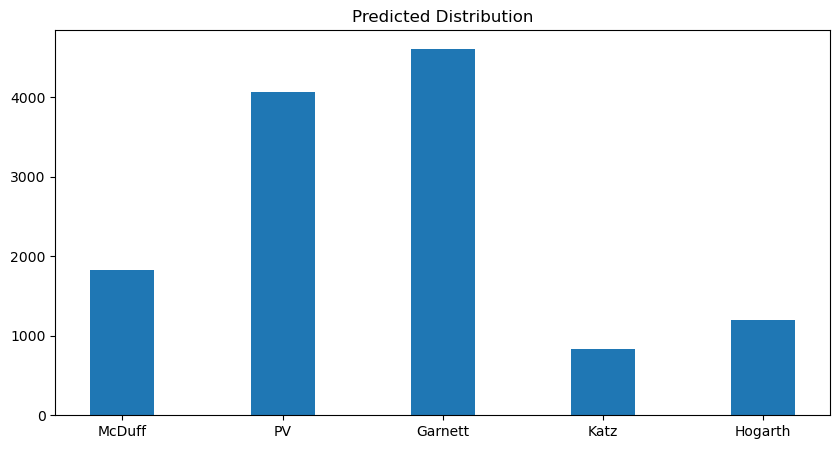

In [39]:
import matplotlib.pyplot as plt


courses = list(pred_count.keys())
values = list(pred_count.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Predicted Distribution")
plt.show()

In [40]:
true_count = {}
for i in id2label.keys():
    count = test_labels.count(i)
    true_count[id2label[i]] = count

true_count

{'McDuff': 2402, 'PV': 1761, 'Garnett': 4085, 'Katz': 1974, 'Hogarth': 2313}

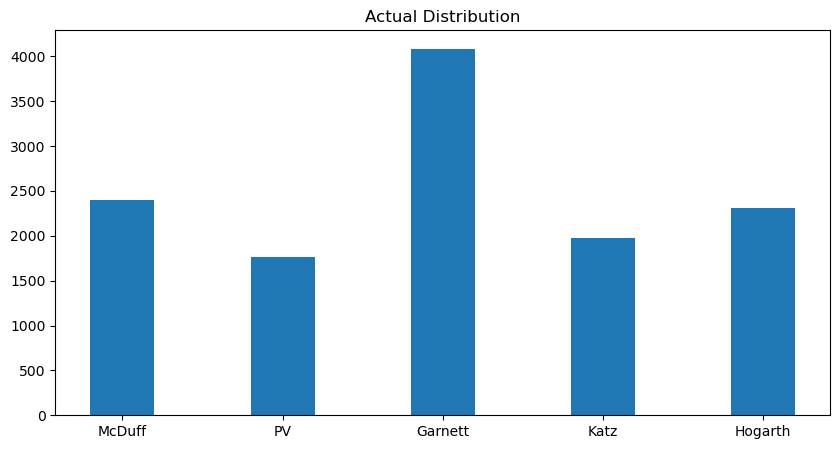

In [41]:
courses = list(true_count.keys())
values = list(true_count.values())
  
fig2 = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Actual Distribution")
plt.show()

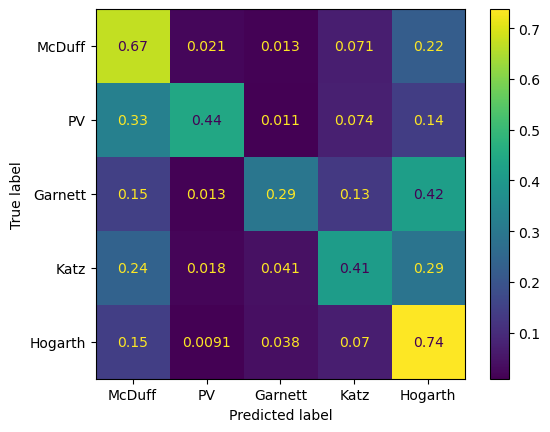

In [46]:
# confusion matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=label2id)
cm_display.plot()
plt.show()